## Overview


### Summary

1. Clean Names 
   - All names have been changed to ease the analysis.

2. Missing Data
   - 'MISSING' strings in the 'sales_channel_id' and 'first_ec_id' columns were replaced with `np.nan` to signify missing data.

3. Data Conversion
   - All columns containing 'date' were converted into datetime format.
   - The remaining columns were converted based on their content type (continuous, integer, or categorical).

4. Dataset Creation
   - Calculated price differences between January and December for all periods.
   - Computed average prices for each customer by aggregating all periods.
   - Combined the aggregated data (from 4.1 and 4.2) and joined it with the customer's dataframe.

5. Split
   - Stratified the dataset to address severe class imbalance (10%).
   - Split the dataset into 80% for training and 20% for testing.

6. Pipelines
   - Tested three preprocessing pipelines:
     - Mode imputation and one-hot encoding for categorical columns.
     - Same as above, but added the `MinMaxScaler()`.
     - Same as above, but added a log+1 transformation for numerical columns with skewness greater than 4.

7. Model Selection
   - Evaluated models using 5-fold cross-validation on training data.
   - Shuffled classes before splitting into batches.
   - Chosen models: Random Forest, Logistic Regression, Lightgbm, and Xgboost.

8. Evaluation Metric
   - Selected F1 score as the main metric to balance precision and recall.
   - Also evaluated precision, recall, accuracy, and roc_auc.

9. Model Evaluation
   - Tested models with three different preprocessing forms in two ways:
     - Without attempting to correct the imbalance.
     - Attempting to correct the imbalance, but without using over/under sampling methods.

10. Final Evaluation
    - Tested models on unseen data to verify their performance during training.

11. Feature Importance
    - Analyzed the importance of each feature in the models' prediction.


### Hypothesis

Our main hypothesis that "Price changes affect customer churn" has been confirmed. However, it is important to note that customer churn is influenced by factors beyond price, including client characteristics. Incorporating these additional factors is crucial for a comprehensive understanding and accurate prediction of customer churn behavior.

### Conclusion

Based on the analysis, the following key findings were identified:

- The average price and volatility in periods 1 and 2 have the most significant impact, with period 1 being more influential.
- Sales channels A and B are the most relevant factors.
- Years of relationship are important, while the presence or absence of gas has little relevance.

Regarding the model evaluation:

- Cross-validation with up/down sampling techniques was deemed unreliable and thus not utilized.
- Balanced models generally outperformed the Random Forest (RF) model, with LightGBM achieving the best F1 score (0.16), recall (0.41), and precision (0.21).
- The RF model had the highest precision score (0.8), but the lowest recall (0.03) among the reference metrics, especially when using balancing techniques.
- Although the proposed model was RF, the current data suggests that LightGBM would be more suitable. 
- However, the **current model is not reliable yet**, and further improvements are needed before deploying it to production.

To enhance performance and address limitations:

- Gathering more data is recommended.
- Including the 'activity_new' category, representing the company's sector, would be essential for better customer segmentation.




## Feature Engineering

### Load libraries

In [1175]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
)
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score
)
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
)

pd.set_option("display.float_format", lambda x: "%.3f" % x)

### Organize features names

In [1176]:
## define variables
SEED = 1234

# organize columns
target = ["churn"]
drop_cols = [
    "id",
    "margin_gross_pow_ele",
    "date_activ",
    "date_end",
    "date_modif_prod",
    "date_renewal",
    "price_e_3_diff_dec_jan",
    "price_p_3_diff_dec_jan",
    "price_e_3_mean",
    "price_e_3_std",
    "price_p_3_mean",
    "price_p_3_std",
    "price_e_1_zero",
    "price_e_2_zero",
    "price_e_3_zero",
    "price_p_1_zero",
    "price_p_2_zero",
    "price_p_3_zero",
]

bi_cols = ["has_gas"]
int_cols = ["forecast_discount_energy", "n_actv_ps", "years_as_client"]
cat_cols = ["sales_channel_id", "first_ec_id"]
num_cols = [
    "cons_12m",
    "cons_gas_12m",
    "cons_last_month",
    "forecast_cons_12m",
    "forecast_cons_year",
    "forecast_meter_rent_12m",
    "forecast_price_e_1",
    "forecast_price_e_2",
    "forecast_price_p_1",
    "imp_cons",
    "margin_net_pow_ele",
    "net_margin",
    "pow_max",
    "price_e_1_diff_dec_jan",
    "price_e_2_diff_dec_jan",
    "price_p_1_diff_dec_jan",
    "price_p_2_diff_dec_jan",
    "price_e_1_mean",
    "price_e_1_std",
    "price_e_2_mean",
    "price_e_2_std",
    "price_p_1_mean",
    "price_p_1_std",
    "price_p_2_mean",
    "price_p_2_std",
]

In [ ]:
sales_channel_map = {
    "foosdfpfkusacimwkcsosbicdxkicaua": "a",
    "lmkebamcaaclubfxadlmueccxoimlema": "b",
    "usilxuppasemubllopkaafesmlibmsdf": "c",
    "ewpakwlliwisiwduibdlfmalxowmwpci": "d",
    "epumfxlbckeskwekxbiuasklxalciiuu": "e",
    "sddiedcslfslkckwlfkdpoeeailfpeds": "f",
    "fixdbufsefwooaasfcxdxadsiekoceaa": "g",
}

first_ec_map = {
    "lxidpiddsbxsbosboudacockeimpuepw": "a",
    "kamkkxfxxuwbdslkwifmmcsiusiuosws": "b",
    "ldkssxwpmemidmecebumciepifcamkci": "c",
    "usapbepcfoloekilkwsdiboslwaxobdp": "d",
    "ewxeelcelemmiwuafmddpobolfuxioce": "e",
}

### Functions

In [1184]:
def threshold_predictions(proba, threshold):
    return (proba >= threshold).astype(int)

def plot_confusion_matrix(y_true, y_pred, labels=['Non-Churned', 'Churned'], title='Confusion Matrix', cmap='Blues', fontsize=14):
    cm = confusion_matrix(y_true, y_pred)

    if labels is None:
        labels = [str(i) for i in range(len(cm))]

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, 
                     xticklabels=labels, yticklabels=labels, annot_kws={"size": fontsize, "ha": 'center', "va": 'center'})
    
    for t in ax.texts:
        t.set_text(t.get_text() + " ")  # Add a small space for better alignment
    
    plt.xlabel('Predicted', fontsize=fontsize)
    plt.ylabel('True', fontsize=fontsize)
    plt.title(title, fontsize=fontsize+2, pad=20)
    plt.show()
    
def find_skewed_features(df, skew_thresh=4):
    """
    Identify skewed numerical features in a DataFrame.

    Args:
    df (pandas.DataFrame): Input dataframe
    skew_thresh (float): Skewness threshold to consider a feature as skewed. Default is 4.

    Returns:
    list: List of skewed features
    """
    # Validate input
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")

    # Calculate skewness for all columns
    skewness = df.skew()

    # Filter out columns where skewness is more than the threshold and minimum value is non-negative
    skewed_feats = skewness[(skewness > skew_thresh) & (df.min() >= 0)].index.tolist()

    return skewed_feats

class SelectiveLog1pTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        self.feature_names_ = X.columns
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed.loc[:, self.columns] = np.log1p(
            X_transformed.loc[:, self.columns]
        )        
        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_




def evaluate_models(
    models, X_train, y_train, cv_splits=5, scoring_metrics=None, seed=None
):
    if scoring_metrics is None:
        scoring_metrics = {
            "precision": make_scorer(precision_score),
            "recall": make_scorer(recall_score),
            "f1": make_scorer(f1_score),
            "accuracy": make_scorer(accuracy_score),
            "roc_auc": make_scorer(roc_auc_score),
        }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)

    results = []
    for model_name, pipeline, Model, model_params in models:
        try:
            model = make_pipeline(pipeline, Model(**model_params, random_state=seed))
            scores = cross_validate(
                model, X_train, y_train, scoring=scoring_metrics, cv=cv, n_jobs=-1
            )
            mean_scores = {
                metric: scores[f"test_{metric}"].mean() for metric in scoring_metrics
            }
            result = {"Classifier": model_name, **mean_scores}
            results.append(result)
        except Exception as e:
            print(f"Error evaluating classifier {model_name}: {e}")

    df_results = pd.DataFrame(results).round(3)
    return df_results

def get_results(pipelines, model_definitions):
    results = []
    for pipeline_name, pipeline in pipelines.items():
        for model_name, Model, model_params in model_definitions:
            model_full_name = f"{pipeline_name}_{model_name}"
            models = [(model_full_name, pipeline, Model, model_params)]
            model_results = evaluate_models(models, X_train, y_train, seed=SEED)
            results.append(model_results)

    # combine all dataframes
    results_df = pd.concat(results)
    return results_df

def evaluate_models(
    models, X_train, y_train, cv_splits=5, scoring_metrics=None, seed=None
):
    if scoring_metrics is None:
        scoring_metrics = {
            "precision": make_scorer(precision_score),
            "recall": make_scorer(recall_score),
            "f1": make_scorer(f1_score),
            "accuracy": make_scorer(accuracy_score),
            "roc_auc": make_scorer(roc_auc_score),
        }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)

    results = []
    for model_name, pipeline, Model, model_params in models:
        try:
            model = make_pipeline(pipeline, Model(**model_params, random_state=seed))
            scores = cross_validate(
                model, X_train, y_train, scoring=scoring_metrics, cv=cv, n_jobs=-1
            )
            mean_scores = {
                metric: scores[f"test_{metric}"].mean() for metric in scoring_metrics
            }
            result = {"Classifier": model_name, **mean_scores}
            results.append(result)
        except Exception as e:
            print(f"Error evaluating classifier {model_name}: {e}")

    df_results = pd.DataFrame(results).round(3)
    return df_results

def get_results(pipelines, model_definitions):
    results = []
    for pipeline_name, pipeline in pipelines.items():
        for model_name, Model, model_params in model_definitions:
            model_full_name = f"{pipeline_name}_{model_name}"
            models = [(model_full_name, pipeline, Model, model_params)]
            model_results = evaluate_models(models, X_train, y_train, seed=SEED)
            results.append(model_results)

    # combine all dataframes
    results_df = pd.concat(results)
    return results_df

def plot_fe(feature_names, feature_importance):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance':feature_importance})
    scaler = MinMaxScaler()
    importance_df['importance_normalized'] = scaler.fit_transform(importance_df[['importance']])

    fig = px.bar(importance_df, x='importance_normalized', y='feature', orientation='h',
                title='Top Factors (Normalized)')

    # Update the bar color
    fig.update_traces(opacity=0.9, marker_color=['#228be6']*100)
    # Update the order of the y-values
    fig.update_layout(
        xaxis_title='Importance',
        yaxis_title='Feature',
        plot_bgcolor='white',
        yaxis={'categoryorder': 'total ascending'},
        height=400,
        width=600
    )
    fig.show()


### Load data

In [1185]:
# load data
train = pd.read_parquet("./data/train.parquet")
test = pd.read_parquet("./data/test.parquet")

# split labels
X_train, y_train = train.drop(columns=target, axis=1), train[target]
X_test, y_test = test.drop(columns=target, axis=1), test[target]

# colect skewed columns names
skewed_cols = find_skewed_features(train[num_cols])

### Preprocessing pipeline

In [1186]:

# Preprocessing pipelines
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")
)

# Preprocessing baseline
null_prep = make_column_transformer(
    (cat_pipe, cat_cols),
    ("drop", drop_cols),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# Preprocessing with scaling
sc_prep = make_column_transformer(
    (cat_pipe, cat_cols),
    ("drop", drop_cols),
    (MinMaxScaler(), num_cols + int_cols),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# Preprocessing with scaling and log1p on skewed columns
num_pipe = make_pipeline(SelectiveLog1pTransformer(skewed_cols), MinMaxScaler())
log_prep = make_column_transformer(
    (cat_pipe, cat_cols),
    ("drop", drop_cols),
    (num_pipe, num_cols + int_cols),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

### Evaluate models

In [6]:
pipelines = {
    "null": null_prep,
    "sc": sc_prep,
    "log_prep": log_prep,
}

models = [
    ("Random Forest", RandomForestClassifier, {}),
    ("Logistic Regression", LogisticRegression, {}),
    ("LightGBM", LGBMClassifier, {}),
    ("XGBoost", XGBClassifier, {}),
]

results_df = get_results(pipelines, models)
results_df.sort_values(by="f1", ascending=False)

,Classifier,precision,recall,f1,accuracy,roc_auc
0,null_XGBoost,0.513,0.095,0.160,0.903,0.543
0,log_prep_XGBoost,0.456,0.088,0.148,0.901,0.538
0,sc_XGBoost,0.452,0.088,0.147,0.901,0.538
0,sc_LightGBM,0.597,0.059,0.107,0.905,0.527
0,log_prep_LightGBM,0.587,0.059,0.107,0.904,0.527
0,null_LightGBM,0.561,0.051,0.093,0.904,0.523
0,null_Random Forest,0.775,0.038,0.072,0.906,0.518
0,sc_Random Forest,0.792,0.036,0.069,0.906,0.518
0,log_prep_Random Forest,0.796,0.035,0.067,0.905,0.517
0,null_Logistic Regression,0.083,0.010,0.017,0.900,0.503


### Evaluate models with balanced treatment for target

In [7]:
balanced_models = [
    ("Random Forest", RandomForestClassifier, {"class_weight": "balanced"}),
    ("Logistic Regression", LogisticRegression, {"class_weight": "balanced"}),
    (
        "LightGBM",
        LGBMClassifier,
        {"class_weight": "balanced", "min_child_samples": int(0.01 * X_train.shape[0])},
    ),
    ("XGBoost", XGBClassifier, {"scale_pos_weight": 8}),
]

results_df = get_results(pipelines, balanced_models)
results_df.sort_values(by="f1", ascending=False)

,Classifier,precision,recall,f1,accuracy,roc_auc
0,log_prep_LightGBM,0.215,0.408,0.282,0.798,0.624
0,null_LightGBM,0.215,0.404,0.280,0.799,0.622
0,sc_LightGBM,0.215,0.402,0.280,0.799,0.622
0,null_XGBoost,0.289,0.222,0.251,0.871,0.582
0,sc_XGBoost,0.274,0.214,0.240,0.869,0.577
0,log_prep_Logistic Regression,0.140,0.637,0.230,0.586,0.609
0,sc_Logistic Regression,0.138,0.645,0.228,0.575,0.606
0,log_prep_XGBoost,0.260,0.204,0.228,0.866,0.571
0,null_Logistic Regression,0.103,0.841,0.184,0.277,0.528
0,log_prep_Random Forest,0.808,0.036,0.069,0.906,0.518


### Final Evaluation

In [1196]:
min_child_samples = int(0.01 * X_train.shape[0])

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      2638
           1       0.20      0.38      0.26       284

    accuracy                           0.79      2922
   macro avg       0.56      0.61      0.57      2922
weighted avg       0.86      0.79      0.82      2922



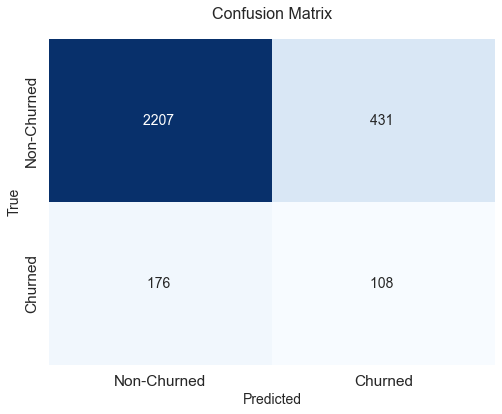

In [1200]:
lgbm_baseline = make_pipeline(
    null_prep,
    LGBMClassifier(
        random_state=SEED,
        class_weight="balanced",
        min_child_samples=min_child_samples,
    ),
)
lgbm_baseline.fit(X_train, y_train.values.ravel())

y_pred_lgbm = lgbm_baseline.predict(X_test)
y_proba = lgbm_baseline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lgbm))
plot_confusion_matrix(y_test, y_pred_lgbm)

In [1095]:
test['prob'] = y_proba
test['pred'] = y_pred

### Using a custom threshold

Optimal threshold: 0.2284, Precision: 0.1195, Recall: 0.7993
              precision    recall  f1-score   support

           0       0.94      0.37      0.53      2638
           1       0.12      0.80      0.21       284

    accuracy                           0.41      2922
   macro avg       0.53      0.58      0.37      2922
weighted avg       0.86      0.41      0.50      2922



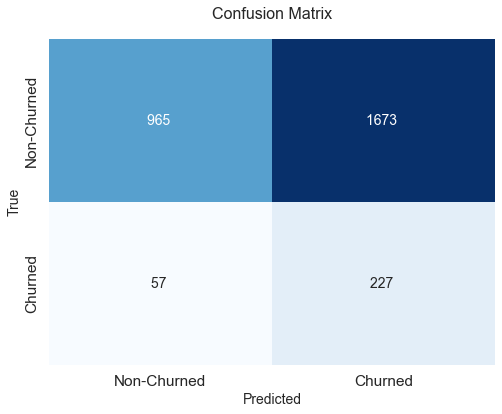

In [58]:
def get_threshold(y_test, y_proba, recall_values=0.7):
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    # Find the threshold value where recall is closest to 0.8
    target_recall = recall_values
    idx = np.abs(recall - target_recall).argmin()
    optimal_threshold = thresholds[idx]
    y_pred = threshold_predictions(y_proba, optimal_threshold)
    print(
        f"Optimal threshold: {optimal_threshold:.4f}, Precision: {precision[idx]:.4f}, Recall: {recall[idx]:.4f}"
    )
    return y_pred

y_pred = get_threshold(y_test, y_proba)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

### Feature Importance

In [104]:
lgbm_model = lgbm_baseline.named_steps['lgbmclassifier']
feature_importance = lgbm_model.feature_importances_
feature_names = lgbm_baseline[0].get_feature_names_out()

plot_fe(feature_names, feature_importance)

### Save model

In [1203]:
import joblib
# Save model
lgbm_baseline = lgbm_baseline.fit(X_train, y_train.values.ravel())
joblib.dump(lgbm_baseline, 'lgbm_baseline_model.pkl')

['lgbm_baseline_model.pkl']

In [1204]:
lgbm_baseline = joblib.load('lgbm_baseline_model.pkl')
lgbm_baselinel

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sales_channel_id',
                                                   'first_ec_id']),
                                                 ('drop', 'drop',
                                                  ['id', 'margin_gross_pow_ele',
                                                   'date_activ', 'date_end',
                                                   'date_mo...
                                                   'price_e_3_diff_dec_jan',
                                                   'price_p_3_diff_dec_jan',
                                                   'price_e_3_mean',
                                                   'price_e_3_std',
                                                   'price_p_3_mean',
                                                   'price_p_3_std',
                                                   'price_e_1_zero',
                                                   'price_e_2_zero',
                                                   'price_e_3_zero',
                                                   'price_p_1_zero',
                                                   'price_p_2_zero',
                                                   'price_p_3_zero'])],
                                   verbose_feature_names_out=False)),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', min_child_samples=116,
                                random_state=1234))])

## Shap

### Transforme os dados antes 

In [1191]:
X_train_t = lgbm_baseline[0].fit_transform(X_train)
X_test_t = lgbm_baseline[0].transform(X_test)

X_train_t = pd.DataFrame(X_train_t, columns=lgbm_baseline[0].get_feature_names_out())
X_test_t = pd.DataFrame(X_test_t, columns=lgbm_baseline[0].get_feature_names_out())


### Selecione uma observação 

In [848]:
import shap
shap.initjs()
#explainer  = shap.TreeExplainer(lgbm_model)
#shap_values = explainer(X_test_t)
#shap_interaction_values = shap.TreeExplainer(lgbm_model).shap_interaction_values(X_test_t)

In [1192]:
explainer_1  = shap.TreeExplainer(lgbm_model)
shap_values_1 = explainer_1.shap_values(X_test_t)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


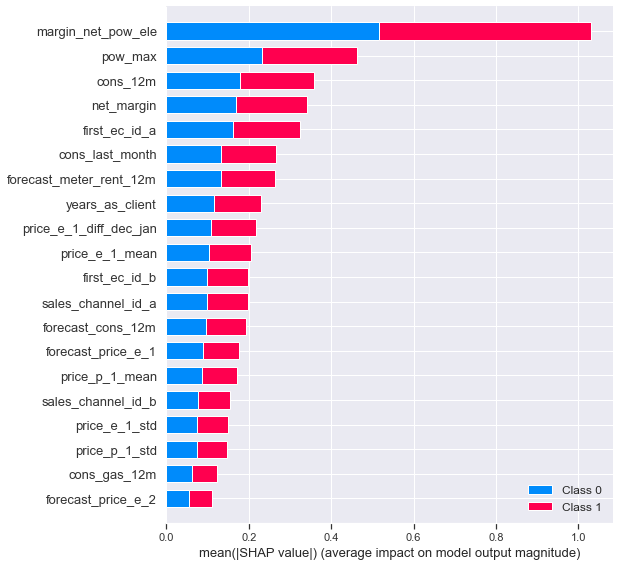

In [1193]:
shap.summary_plot(lgbm_shap_values, X_test_t)

In [1030]:
df_shap_1 =pd.DataFrame(data=shap_values_1[1],columns=X_test_t.columns, index=X_test_t.index)
df_shap_0 =pd.DataFrame(data=shap_values_1[0],columns=X_test_t.columns, index=X_test_t.index)

In [1040]:
df_shap_1.abs().mean()

sales_channel_id_a         0.099
sales_channel_id_b         0.078
sales_channel_id_c         0.008
sales_channel_id_d         0.024
sales_channel_id_e         0.000
sales_channel_id_f         0.000
sales_channel_id_g         0.000
first_ec_id_a              0.162
first_ec_id_b              0.099
first_ec_id_c              0.008
first_ec_id_d              0.000
cons_12m                   0.179
cons_gas_12m               0.062
cons_last_month            0.133
forecast_cons_12m          0.096
forecast_cons_year         0.045
forecast_meter_rent_12m    0.132
forecast_price_e_1         0.088
forecast_price_e_2         0.055
forecast_price_p_1         0.012
imp_cons                   0.043
margin_net_pow_ele         0.516
net_margin                 0.170
pow_max                    0.232
price_e_1_diff_dec_jan     0.109
price_e_2_diff_dec_jan     0.023
price_p_1_diff_dec_jan     0.039
price_p_2_diff_dec_jan     0.005
price_e_1_mean             0.102
price_e_1_std              0.075
price_e_2_

In [966]:
explainer = shap.TreeExplainer(
    lgbm_model,
    data=X_test_t,
    feature_perturbation="interventional",
    model_output="probability",
)
shap_values = explainer(X_test_t)

 97%|=================== | 2832/2922 [00:31<00:00]       

In [1037]:
shap_values_prob = explainer.shap_values(X_test_t)

100%|===================| 2908/2922 [00:30<00:00]        

In [1045]:
df_shap_p = pd.DataFrame(data=shap_values_prob,columns=X_test_t.columns, index=X_test_t.index)
df_shap_p.abs().mean()

sales_channel_id_a         0.017
sales_channel_id_b         0.010
sales_channel_id_c         0.002
sales_channel_id_d         0.005
sales_channel_id_e         0.000
sales_channel_id_f         0.000
sales_channel_id_g         0.000
first_ec_id_a              0.028
first_ec_id_b              0.016
first_ec_id_c              0.001
first_ec_id_d              0.000
cons_12m                   0.028
cons_gas_12m               0.012
cons_last_month            0.024
forecast_cons_12m          0.018
forecast_cons_year         0.009
forecast_meter_rent_12m    0.025
forecast_price_e_1         0.017
forecast_price_e_2         0.010
forecast_price_p_1         0.003
imp_cons                   0.008
margin_net_pow_ele         0.109
net_margin                 0.037
pow_max                    0.047
price_e_1_diff_dec_jan     0.022
price_e_2_diff_dec_jan     0.004
price_p_1_diff_dec_jan     0.011
price_p_2_diff_dec_jan     0.001
price_e_1_mean             0.020
price_e_1_std              0.015
price_e_2_

In [954]:
import numpy as np
import pandas as pd

class waterfall():
    def __init__(self, data, shap_values, 
                       base_value, 
                       path = "",
                       green_color ='#29EA38' , 
                       red_color = '#FB3C62', 
                       n=8,
                       title="The Prediction " ,
                       x_lab="",
                       y_lab="The predicted value",
                       formatting = "{:,.2f}",
                       rotation_value = 90,
                       figsize = (7,5)
                
                ):
        self.data        = data
        self.shap_values = shap_values
        self.base_value  = base_value
        self.green_color = green_color
        self.red_color   = red_color
        self.n           = n
        self.title       = title
        self.x_lab       = x_lab
        self.y_lab       = y_lab
        self.formatting  = formatting
        self.rotation_value = rotation_value
        self.figsize     = figsize
        self._plot       = pd.DataFrame()
        self.path        = path

    def obs_to_explain(self):
        '''
          - data: the observation. It is a Pandas series. The index contains the variable names 
          - shap_values: the shap_values for the above observation 
          - base_value: the base_value, which is the expected value or the mean of the target value of the training set
          - green_color: the color for the up bar
          - red_color: the color for the down bar
          - for_plot: a sorted data frame by the absolute value of shape in descending order
          - n: show the top n (default) variables. The rest variables are summed up into "others"
        '''
        for_plot = pd.DataFrame({'data':np.round(self.data,2),
                                 'shap':self.shap_values,
                                 'shap_abs': np.abs(self.shap_values),
                                 'label': self.data.index
                                })
        for_plot = for_plot.sort_values(by='shap_abs',ascending=False)

        # Split the variables into n and the rest. Only show the top n
        for_plot1 = for_plot.iloc[0:self.n,:]
        for_plot2 = for_plot.iloc[self.n:,:]

        # Sum up the rest as 'others'
        rest = pd.DataFrame({'data': '','shap':for_plot2['shap'].sum(), 'label': 'Others'},index=['others'])
        for_plot = for_plot1.append(rest)

        # Sum up the rest into 'others'
        base = pd.DataFrame({'data': np.round(self.base_value,2),'shap':self.base_value, 'label': 'Base value'},index=['base_value'])
        for_plot = base.append(for_plot)

        for_plot['blank'] = for_plot['shap'].cumsum().shift(1).fillna(0) # +  base_value
        for_plot['label'] = + for_plot['label'] + " =" + for_plot['data'].map(str) 
        for_plot['color'] = np.where(for_plot['shap']>0,self.green_color,self.red_color)
        for_plot = for_plot.drop(['data','shap_abs'],axis=1)
        
        self.for_plot = for_plot
        
        return(for_plot ) 
    
    def plt_plot(self):
        '''
          - x_lab, y_lab: the x label and y label
          - formatting: show the value of each bar 
        '''

        fig, ax = plt.subplots(figsize=self.figsize)

        # Plot the waterfall    
        plt.bar(range(0,len(self.for_plot.index)), self.for_plot['shap'], width=0.6,
              bottom=self.for_plot['blank'],     color=self.for_plot['color'])     

        #axis labels
        plt.xlabel("\n" + self.x_lab)
        plt.ylabel(self.y_lab + "\n")

        #Get the y-axis position for the labels
        y_height = self.for_plot.shap.cumsum().shift(1).fillna(0)

        plot_max = self.for_plot['shap'].max()
        plot_min = self.for_plot['shap'].min()
        pos_offset = plot_max / 40
        plot_offset = plot_max / 15 
        total = self.for_plot.sum().shap 

        # label the shap values
        loop = 0
        for index, row in self.for_plot.iterrows():
            # For the last item in the list, we don't want to double count
            if row['shap'] == total:
                    y = y_height[loop]
            else:
                    y = y_height[loop] + row['shap']

            if row['shap'] > 0:
                    y += (pos_offset*2)
                    plt.annotate(self.formatting.format(row['shap']),(loop,y),ha="center", color = self.green_color, fontsize=10)
            else:
                    y -= (pos_offset*4)
                    plt.annotate(self.formatting.format(row['shap']),(loop,y),ha="center", color = self.red_color, fontsize=10)
            loop+=1

        # Range of the ylim
        plt.ylim(plot_min-round(3.6*plot_offset, 7) ,plot_max+round(3.6*plot_offset, 7))

        #Rotate the labels
        plt.xticks(range(0,len(self.for_plot)), self.for_plot['label'], rotation=self.rotation_value)

        #add the base value line and title
        #plt.axhline(base_value, color='black', linewidth = 0.6, linestyle="dashed")
        plt.title(self.title)

        import matplotlib.patches as mpatches
        red_patch = mpatches.Patch(color=self.red_color, label='Down')
        green_patch = mpatches.Patch(color=self.green_color, label='Up')
        plt.legend(handles=[red_patch,green_patch],bbox_to_anchor=[1, 1], loc='upper left')

        #plt.tight_layout()
        #return(fig)
    
    def plotly_plot(self):
        import plotly.graph_objects as go
        import numpy as np

        ys = self.for_plot['shap'].round(2)
        ms = list(np.repeat('relative',len(ys)))
        xs = list(self.for_plot['label'].values)
        texts = self.for_plot['shap'].round(2)

        fig = go.Figure(go.Waterfall(
            name = "20", orientation = "v",
            measure = ms,
            x = xs,
            textposition = "outside",
            text = texts,
            y = ys,
            connector = {"line":{"color":"rgb(63, 63, 63)"} },
           ) )


        layout = go.Layout(
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)'
        )

        fig.update_layout(
            template="plotly_white",
            title ="The prediction of this observation is " ,
            margin=dict(l=120, r=120, t=60, b=60),
            yaxis=dict(
                title_text="The predicted value" 
            ),
            xaxis =dict(
                tickangle = -90,
                title_text = "Variables")
        )
        fig.write_html(self.path + "/f.html", auto_open=True)

obs = 1

#explainer
#shap_values
#y_proba
#y_pred
path = "./data"
base_value = y_train.mean()
shap_to = waterfall(X_test_t.iloc[obs,:],
                              base_value = base_value,
                              shap_values = shap_values.values[obs],
                              path = path,
                              title="The Prediction " ,
                              x_lab="",
                              y_lab="The predicted value",
                              formatting = "{:,.2f}",
                              rotation_value = 90,
                              figsize = (7,5)
                      
                      )
shap_to.obs_to_explain()        

,shap,label,blank,color
base_value,NaN,Base value =nan,0.000,#FB3C62
margin_net_pow_ele,0.120,margin_net_pow_ele =0.61,0.000,#29EA38
pow_max,-0.084,pow_max =0.37,0.120,#FB3C62
forecast_meter_rent_12m,-0.061,forecast_meter_rent_12m =0.22,0.036,#FB3C62
net_margin,-0.056,net_margin =0.4,-0.026,#FB3C62
price_p_1_mean,-0.044,price_p_1_mean =0.69,-0.082,#FB3C62
cons_last_month,-0.025,cons_last_month =0.5,-0.126,#FB3C62
forecast_price_e_1,0.021,forecast_price_e_1 =0.42,-0.151,#29EA38
years_as_client,-0.021,years_as_client =0.42,-0.130,#FB3C62
others,0.039,Others =,-0.150,#29EA38


The predicted value is: 0.214
The expected value is: churn   0.097
dtype: float64
The predicted group is: 0
The Actual value is: churn    0
Name: 1, dtype: int8


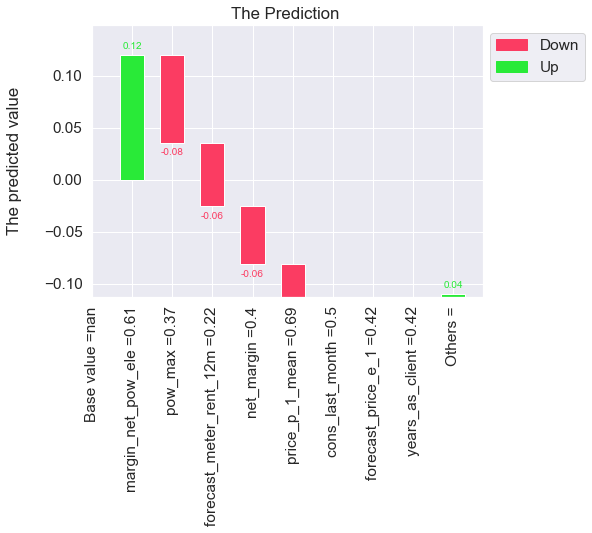

In [962]:
obs =1
print("The predicted value is: " +  str(np.round(y_proba[obs],3)))
print("The expected value is: " +  str(np.round(base_value,3)))
print("The predicted group is: " +  str(np.round(y_pred[obs],0)))
print("The Actual value is: " +  str(np.round(y_test.loc[obs],3)))
shap_to.obs_to_explain()
shap_to.plt_plot()

In [1005]:
df_shap_values = pd.DataFrame(data=shap_values.values,columns=X_test_t.columns, index=X_test_t.index)

# calculate the average absolute SHAP value of a column, and then rank the features based on this average abs SHAP value
values_abs = abs(df_shap_values)
values_abs_mean = values_abs.mean(axis=0)
values_abs_mean_sorted = values_abs_mean.sort_values(ascending = False)
#values_abs_mean_sorted.to_csv('SHAP_values_sorted_average_%s.txt'%args.save,sep='\t',header=True,index=True)
values_abs_mean_sorted

margin_net_pow_ele         0.109
pow_max                    0.047
net_margin                 0.037
first_ec_id_a              0.028
cons_12m                   0.028
forecast_meter_rent_12m    0.025
cons_last_month            0.024
price_e_1_diff_dec_jan     0.022
years_as_client            0.020
price_e_1_mean             0.020
forecast_cons_12m          0.018
forecast_price_e_1         0.017
sales_channel_id_a         0.017
price_p_1_std              0.017
price_p_1_mean             0.017
first_ec_id_b              0.016
price_e_1_std              0.015
cons_gas_12m               0.012
price_p_1_diff_dec_jan     0.011
sales_channel_id_b         0.010
price_p_2_mean             0.010
forecast_price_e_2         0.010
forecast_cons_year         0.009
price_e_2_std              0.009
imp_cons                   0.008
price_p_2_std              0.008
price_e_2_mean             0.006
sales_channel_id_d         0.005
price_e_2_diff_dec_jan     0.004
forecast_price_p_1         0.003
has_gas   

In [1009]:

df_feature_importance = pd.DataFrame(columns=['feature','importance'])
for col in df_shap_values.columns:
    importance = df_shap_values[col].abs().mean()
    df_feature_importance.loc[len(df_feature_importance)] = [col,importance]
df_feature_importance = df_feature_importance.sort_values('importance',ascending=False)
df_feature_importance

,feature,importance
21,margin_net_pow_ele,0.109
23,pow_max,0.047
22,net_margin,0.037
7,first_ec_id_a,0.028
11,cons_12m,0.028
16,forecast_meter_rent_12m,0.025
13,cons_last_month,0.024
24,price_e_1_diff_dec_jan,0.022
38,years_as_client,0.020
28,price_e_1_mean,0.020


- Maior margin_net_pow_ele (net margin on power subscription) leva a maior probabilidade de um consumidor ir embora
- 

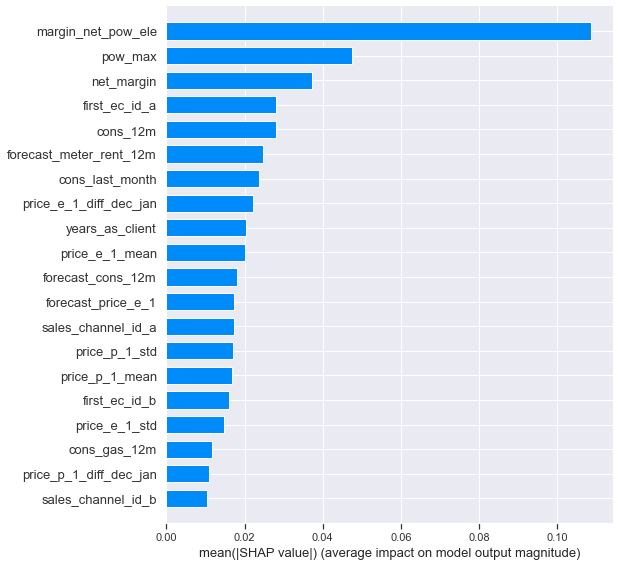

In [1049]:
shap.summary_plot(shap_values, X_test_t, plot_type='bar')

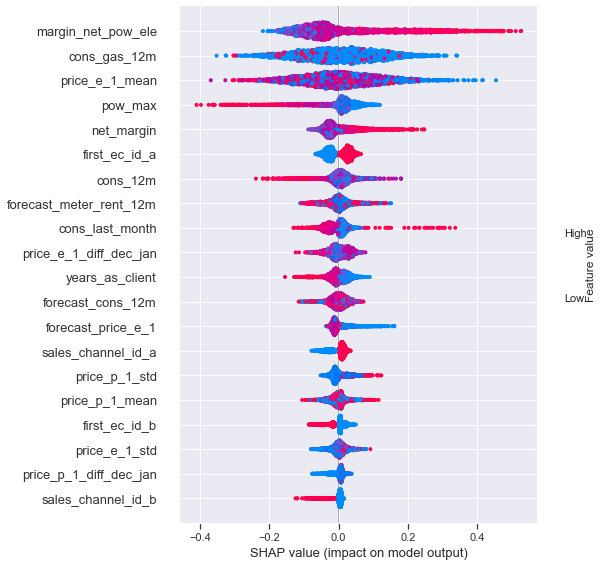

In [860]:
shap.summary_plot(shap_values, X_test_t)

In [ ]:
explainer2 = shap.TreeExplainer(lgbm_model)
shap_values2 = explainer2(X_test_t)

In [883]:
# force plot of first row for class 1
class_idx = 1
row_idx = 5
expected_value2 = explainer2.expected_value[class_idx]
shap_value1 = shap_values2[:, :, class_idx].values[row_idx]

shap.force_plot(
    base_value=expected_value2,
    shap_values=shap_value1,
    features=X_test_t.iloc[row_idx, :],
    link="logit",
)

In [1001]:
model_proba= lgbm_model.predict_proba(X_test_t.iloc[[1]])
model_proba

array([[0.78643082, 0.21356918]])

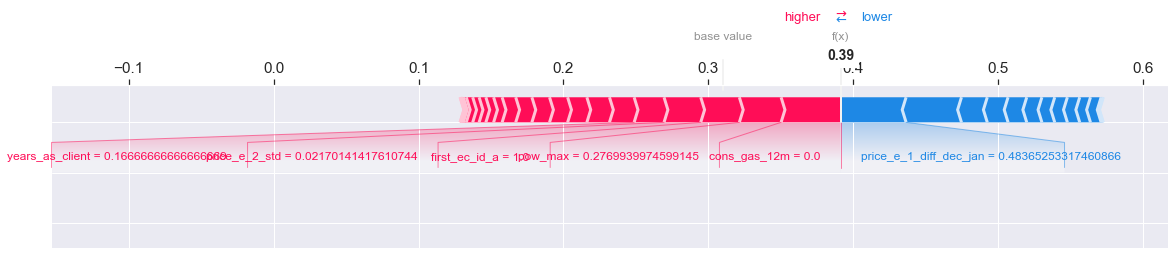

In [892]:
# force plot of first row for class 1 - PREVE VALOR DIFERENTE
row_idx = 4
#shap_value = shap_values.values[row_idx]
shap_value = shap_values[:, :].values[row_idx]
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_value, 
    features=X_test_t.iloc[row_idx, :],
    show=True, 
    matplotlib=True
)

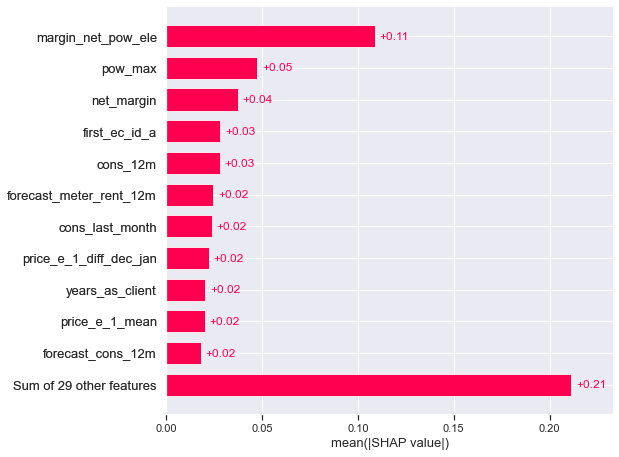

In [667]:
# Global bar plot
shap.plots.bar(shap_values,  max_display=12)

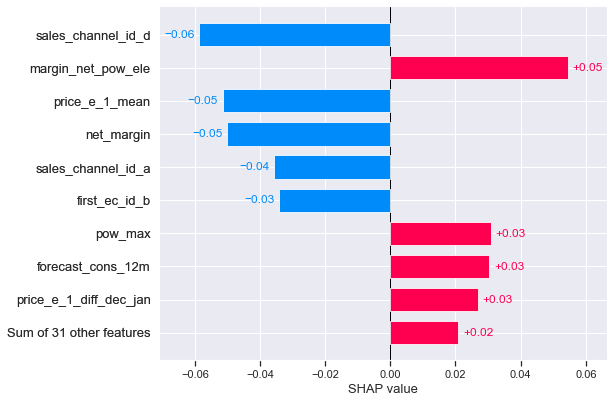

In [674]:
# Local bar plot
shap.plots.bar(shap_values[5])

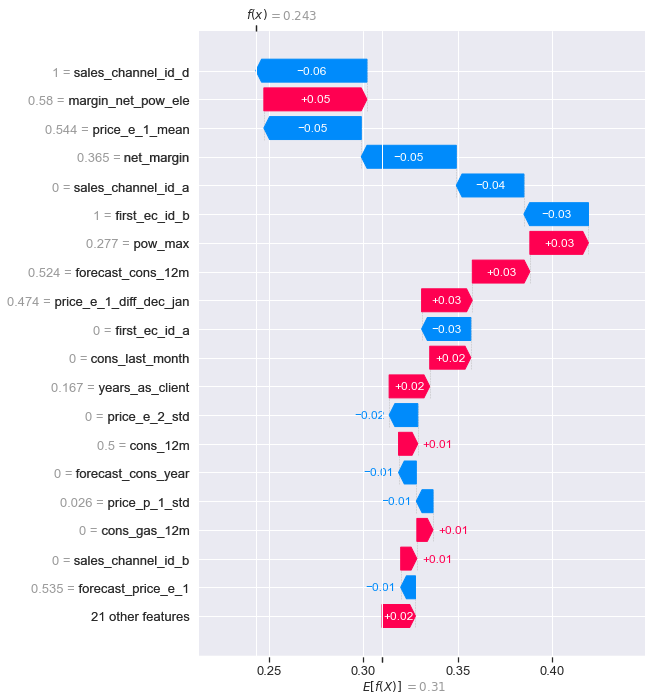

In [678]:
# local explanation on row 5
shap.plots.waterfall(shap_values[5], max_display=20)

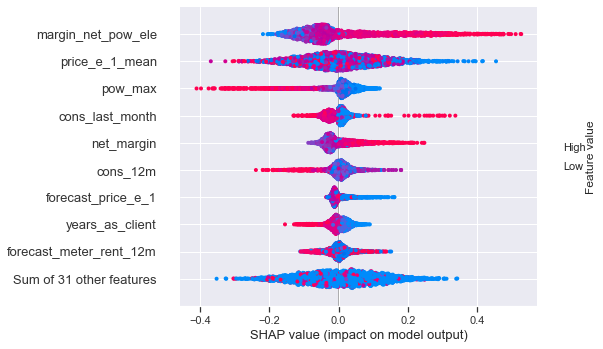

In [680]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0))

### Lift

In [1048]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plotly_lift_curve(
    lift_curve_df, cutoff=None, percentage=False, add_wizard=True, round=2):
    """returns a lift plot for values

    Args:
        lift_curve_df (pd.DataFrame): generated with get_liftcurve_df(pred_proba, y)
        cutoff (float, optional): cutoff above which samples get classified as
            positive. Defaults to None.
        percentage (bool, optional): Display percentages instead of absolute
            numbers along axis. Defaults to False.
        add_wizard (bool, optional): Add a line indicating how a perfect model
            would perform ("the wizard"). Defaults to True
        round (int, optional): Rounding to apply to floats. Defaults to 2.

    Returns:
        Plotly fig
    """

    if percentage:
        model_text = [
            f"model selected {pos:.{round}f}% of all positives in first {i:.{round}f}% sampled<br>"
            + f"precision={precision:.{round}f}% positives in sample<br>"
            + f"lift={pos/exp:.{round}f}"
            for (i, pos, exp, precision) in zip(
                lift_curve_df.index_percentage,
                lift_curve_df.cumulative_percentage_pos,
                lift_curve_df.random_cumulative_percentage_pos,
                lift_curve_df.precision,
            )
        ]

        random_text = [
            f"random selected {exp:.{round}f}% of all positives in first {i:.{round}f}% sampled<br>"
            + f"precision={precision:.{round}f}% positives in sample"
            for (i, pos, exp, precision) in zip(
                lift_curve_df.index_percentage,
                lift_curve_df.cumulative_percentage_pos,
                lift_curve_df.random_cumulative_percentage_pos,
                lift_curve_df.random_precision,
            )
        ]
    else:
        model_text = [
            f"model selected {pos} positives out of {i}<br>"
            + f"precision={precision:.{round}f}<br>"
            + f"lift={pos/exp:.{round}f}"
            for (i, pos, exp, precision) in zip(
                lift_curve_df["index"],
                lift_curve_df.positives,
                lift_curve_df.random_pos,
                lift_curve_df.precision,
            )
        ]
        random_text = [
            f"random selected {int(exp)} positives out of {i}<br>"
            + f"precision={precision:.{round}f}"
            for (i, pos, exp, precision) in zip(
                lift_curve_df["index"],
                lift_curve_df.positives,
                lift_curve_df.random_pos,
                lift_curve_df.random_precision,
            )
        ]

    trace0 = go.Scatter(
        x=lift_curve_df["index_percentage"].values
        if percentage
        else lift_curve_df["index"],
        y=np.round(lift_curve_df.cumulative_percentage_pos.values, round)
        if percentage
        else np.round(lift_curve_df.positives.values, round),
        name="model",
        text=model_text,
        hoverinfo="text",
    )

    trace1 = go.Scatter(
        x=lift_curve_df["index_percentage"].values
        if percentage
        else lift_curve_df["index"],
        y=np.round(lift_curve_df.random_cumulative_percentage_pos.values, round)
        if percentage
        else np.round(lift_curve_df.random_pos.values, round),
        name="random",
        text=random_text,
        hoverinfo="text",
    )
    if add_wizard:
        if percentage:
            trace2 = go.Scatter(
                x=[0.0, lift_curve_df.random_precision[0], 100],
                y=[0.0, 100, 100],
                text=[
                    "0%, 0%",
                    f"{lift_curve_df.random_precision[0]:.2f}%, 100%",
                    "100, 100%",
                ],
                name="perfect",
                hoverinfo="text",
            )
        else:
            trace2 = go.Scatter(
                x=[0.0, lift_curve_df["positives"].max(), lift_curve_df["index"].max()],
                y=[
                    0.0,
                    lift_curve_df["positives"].max(),
                    lift_curve_df["positives"].max(),
                ],
                name="perfect",
            )

        data = [trace2, trace0, trace1]
    else:
        data = [trace0, trace1]

    fig = go.Figure(data)

    fig.update_layout(
        title=dict(text="Lift curve", x=0.5, font=dict(size=18)),
        xaxis_title="Percentage sampled" if percentage else "Number sampled",
        yaxis_title="Percentage of positive" if percentage else "Number of positives",
        xaxis=dict(spikemode="across"),
        hovermode="x",
        plot_bgcolor="#fff",
    )

    fig.update_layout(legend=dict(xanchor="center", y=0.9, x=0.1))
    if percentage:
        fig.update_layout(xaxis=dict(range=[0, 100]))
    else:
        fig.update_layout(xaxis=dict(range=[0, lift_curve_df["index"].max()]))

    if cutoff is not None:
        # cutoff_idx = max(0, (np.abs(lift_curve_df.pred_proba - cutoff)).argmin() - 1)
        cutoff_idx = max(0, len(lift_curve_df[lift_curve_df.pred_proba >= cutoff]) - 1)
        if percentage:
            cutoff_x = lift_curve_df["index_percentage"].iloc[cutoff_idx]
        else:
            cutoff_x = lift_curve_df["index"].iloc[cutoff_idx]

        cutoff_n = lift_curve_df["index"].iloc[cutoff_idx]
        cutoff_pos = lift_curve_df["positives"].iloc[cutoff_idx]
        cutoff_random_pos = int(lift_curve_df["random_pos"].iloc[cutoff_idx])
        cutoff_lift = np.round(
            lift_curve_df["positives"].iloc[cutoff_idx]
            / lift_curve_df.random_pos.iloc[cutoff_idx],
            1,
        )
        cutoff_precision = np.round(lift_curve_df["precision"].iloc[cutoff_idx], 2)
        cutoff_random_precision = np.round(
            lift_curve_df["random_precision"].iloc[cutoff_idx], 2
        )

        fig.update_layout(
            shapes=[
                dict(
                    type="line",
                    xref="x",
                    yref="y",
                    x0=cutoff_x,
                    x1=cutoff_x,
                    y0=0,
                    y1=100.0 if percentage else lift_curve_df.positives.max(),
                )
            ]
        )
        fig.update_layout(
            annotations=[
                go.layout.Annotation(
                    x=cutoff_x, y=5, yref="y", text=f"cutoff={cutoff:.{round}f}"
                ),
                go.layout.Annotation(
                    x=0.5,
                    y=0.4,
                    text=f"Model: {cutoff_pos} out {cutoff_n} ({cutoff_precision:.{round}f}%)",
                    showarrow=False,
                    align="right",
                    xref="paper",
                    yref="paper",
                    xanchor="left",
                    yanchor="top",
                ),
                go.layout.Annotation(
                    x=0.5,
                    y=0.33,
                    text=f"Random: {cutoff_random_pos} out {cutoff_n} ({cutoff_random_precision:.{round}f}%)",
                    showarrow=False,
                    align="right",
                    xref="paper",
                    yref="paper",
                    xanchor="left",
                    yanchor="top",
                ),
                go.layout.Annotation(
                    x=0.5,
                    y=0.26,
                    text=f"Lift: {cutoff_lift}",
                    showarrow=False,
                    align="right",
                    xref="paper",
                    yref="paper",
                    xanchor="left",
                    yanchor="top",
                ),
            ]
        )
    fig.update_layout(margin=dict(t=40, b=40, l=40, r=40))
    return fig


def get_lift_df(y_proba, y, pos_label=1, n_rows=100):
    """returns a pd.DataFrame that can be used to generate a lift curve plot.

    Args:
        pred_probas (np.ndarray): predicted probabilities of the positive class
        y (np.ndarray): the actual labels (y_true), encoded 0, 1 [, 2, 3, etc]
        pos_label (int): label of the positive class. Defaults to 1.

    Returns:
        pd.DataFrame with columns=['pred_proba', 'y', 'index', 'index_percentage',
                'positives', 'precision', 'cumulative_percentage_pos',
                'random_pos', 'random_precision', 'random_cumulative_percentage_pos']
    """    
    lift_df = (
        pd.DataFrame({"pred_proba": y_proba, "y": y.values.ravel()})
        .sort_values("pred_proba", ascending=False)
        .reset_index(drop=True)
    )
    lift_df["index"] = (lift_df.index + 1).astype("int32")
    lift_df["index_percentage"] = (100 * lift_df["index"] / len(lift_df)).astype("float32")

    lift_df["positives"] = (lift_df.y == pos_label).astype(int).cumsum()
    lift_df["precision"] = (100 * (lift_df["positives"] / lift_df["index"])).astype(
        "float32"
    )

    lift_df["cumulative_percentage_pos"] = (
        100 * (lift_df["positives"] / (lift_df.y == pos_label).astype(int).sum())
    ).astype("float32")
    lift_df["random_pos"] = (
        (lift_df.y == pos_label).astype(int).mean() * lift_df["index"]
    ).astype("float32")

    lift_df["random_precision"] = (
        100 * (lift_df["random_pos"] / lift_df["index"])
    ).astype("float32")

    lift_df["random_cumulative_percentage_pos"] = (
        100 * (lift_df["random_pos"] / (lift_df.y == pos_label).astype(int).sum())
    ).astype("float32")

    for y_label in range(lift_df['y'].nunique()):
        lift_df["precision_" + str(y_label)] = (
            100 * (lift_df.y == y_label).astype(int).cumsum() / lift_df["index"]
        )
    
    if len(lift_df) > 100:
        lift_df = lift_df.iloc[
            np.linspace(0, len(lift_df), num=n_rows, dtype=int, endpoint=False)
        ]
    return lift_df
#lgbm_model.predict_proba(X_test_t.iloc[[1]])

# Business impact of discount

We conduct a brief analysis on the discount strategy proposed. This is just 1 way to solve it, there may be many other ways!

The SME division head proposed that we give a 20% discount to high propensity to churn customers. We can assume to start that everyone who is offered a discount will accept it.

## Workflow

Our task is to calculate the forecast revenue for the set of customers:

1. When no discount is offered
2. And when a discount is offered based on a probability cutoff to decide who should receive the 20% discount

And hence to decide where the cut-off should be set in order to maximise revenue

---

### Calculate a baseline revenue estimate (no intervention)

Calculate a baseline estimate of the electricity revenue for every customer for the next twelve months based on the forecast consumption and forecast
price and actual churn outcome. Call this `basecase_revenue`.

- For customers who end up churning, we should reduce our forecast revenue calculation by 91.9% to account for the customers churn some time between January 2016 and the start of March 2016. (Not knowing when they churn, a reasonable assumption for the lost revenue is the average of 100%, corresponding to churn on 1 January 2016, and 83.9%, corresponding to churn at the end of February, or 59 days into a 365 day year). Call this new variable `basecase_revenue_after_churn`, ie `basecase_revenue_after_churn` = `basecase_revenue`*(1 -0.919 * `churn`)

In [1088]:
# Electricity revenue for each customer consists of energy consumption (amount * price) and the meter rent
# (the power price may also play a role, but we will ignore it for now since we need to ask the client for more data)
# Note that we need to reverse the log10-transformation from the data cleaning step
test['basecase_revenue'] = test['forecast_cons_12m'] * test['forecast_price_p_1'] + test['forecast_meter_rent_12m']

# Taking churn into account 
#(test.query('churn==1')['basecase_revenue']).sum()
test['basecase_revenue_after_churn'] = test['basecase_revenue'] * (1 - 0.919 * test['churn'])

In [1106]:
test['basecase_revenue'].describe()

count      2922.000
mean      80126.940
std      110540.644
min           0.000
25%       22151.632
50%       49205.793
75%      102281.874
max     2856494.244
Name: basecase_revenue, dtype: float64

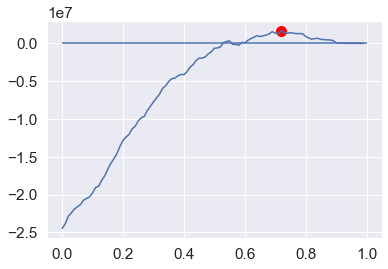

Maximum benefit at cutoff 0.72 with revenue delta of $1,666,597.36


In [1132]:
def get_rev_delta(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2) -> float:
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn'] # receita com churn
    # Churn predicted => discount is given => customer stays for full year, independent of whether the prediction
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[pred['prob'] >= cutoff, 'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()


def plot_tradeoff(rev_deltas: pd.Series):
    # Plot the revenue deltas
    rev_deltas.plot()
    # Mark optimal point
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s=100, c='red')
    # Reference line for break-even
    plt.hlines(0, 0, 1)
    plt.show()
    print(f'Maximum benefit at cutoff {max_pred} with revenue delta of ${rev_deltas.loc[max_pred]:,.2f}')

# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(test, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
plot_tradeoff(rev_deltas)

### Ajustando o custo em torno de clientes são mais valiosos

In [1144]:
def get_rev_delta_high_value(
    pred: pd.DataFrame, cutoff: float = 0.5, discount: float = 0.2, min_rev: float = 500
):
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff and rev
    """
    pred["discount_revenue"] = pred["basecase_revenue_after_churn"]
    # Churn predicted => discount is given for high-value customers => customer stays for full year, independent
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[
        (pred["prob"] >= cutoff) & (pred["basecase_revenue"] > min_rev),
        "discount_revenue",
    ] = pred["basecase_revenue"] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred["revenue_delta"] = (
        pred["discount_revenue"] - pred["basecase_revenue_after_churn"]
    )
    return pred["revenue_delta"].sum()

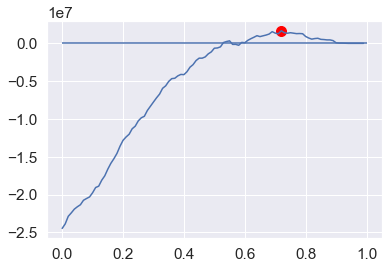

Maximum benefit at cutoff 0.72 with revenue delta of $1,666,634.66


In [1146]:
## Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas_high_value = pd.Series({cutoff: get_rev_delta_high_value(test, cutoff=cutoff, min_rev=500) for cutoff in np.arange(0, 1, 0.01)})
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
plot_tradeoff(rev_deltas_high_value)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2638
           1       0.50      0.15      0.23       284

    accuracy                           0.90      2922
   macro avg       0.71      0.57      0.59      2922
weighted avg       0.87      0.90      0.88      2922



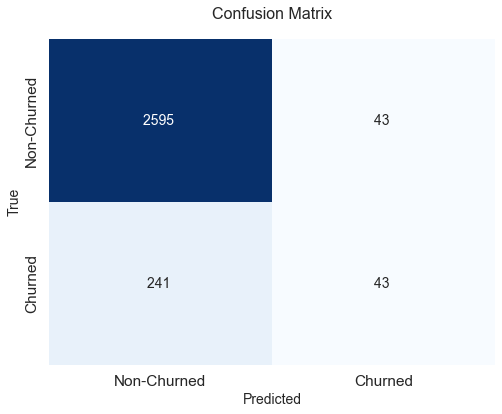

In [1125]:

y_pred_cost = threshold_predictions(y_proba, 0.72)
print(classification_report(y_test, y_pred_cost))
plot_confusion_matrix(y_test, y_pred_cost)